# Block VQE by Qubit

Here we will split the Hilbert space into two groups, one which will be calculated classically and the other with will be calculated using block-VQE.  Instead of splitting the Hilbert space into spin-up and spin-down as we did before, here I will split the Hilbert space into general sets of qubits.  

The wavefunction is divided into classical and quantum parts
$$
    |\psi> = \sum_c \alpha_c |c>|\psi_{qc}>
$$
where $|c>$ is a basis state in the classical section and $|\psi_q>$ is the wavefunction in the quantum section.  The weights $\alpha_c$ have to be solved classically while the wavefunctions $|\psi_{qc}>$ will be updated using VQE.  

Let's do a simple X-Y-Z model with closed boundary conditions to test the algorithm.  
$$ 
    H =  \sum_{i} \left(x X_{i}X_{i+1} + y Y_{i} Y_{i+1} + z Z_{i} Z_{i+1}\right) 
$$

Let us take the first $N_c$ qubits to be in the classical sector.  Then we can take energy expectation values as,
\begin{equation}
\begin{split}
&<\psi|H|\psi> = \sum_{cc'}\alpha_c\alpha_c'<\psi_{qc'}|<c'| H |c> |\psi_{qc}>=
\\
& \sum_{cc'}\alpha_c\alpha_c' \left( \sum_{i=0}^{N_c-2}  <c'|\left(x X_{i}X_{i+1} + y Y_{i} Y_{i+1} + z Z_{i} Z_{i+1}\right)|c><\psi_{qc'}|\psi_{qc}>  + \delta_{cc'}\sum_{i=N_c+1}^{N} <\psi_{qc'}| \ \left(x X_{i}X_{i+1} + y Y_{i} Y_{i+1} + z Z_{i} Z_{i+1}\right) |\psi_{qc}> \right) 
\\
&+ \sum_{cc'}\alpha_c\alpha_c'  \left( <c'|X_{N_c-1}|c><\psi_{qc'}|X_{N_c}|\psi_{qc}> + <c'|Y_{N_c-1}|c> <\psi_{qc'}|Y_{N_c}|\psi_{qc}> + <c'|Z_{N_c-1}|c><\psi_{qc'}|Z_{N_c}|\psi_{qc}> \right) 
\end{split}
\end{equation}

Anything in the classical brakets are calculated classically while anything in the quantum brackets are calculated using quantum hardware.  Notice that some of the quantum brakets are wieghted by classical brackets.  This is not a problem.  

## Classical part

### Define Pauli Matrices

Let us define the Pauli matrices so we can do the classical calculations.

In [1]:
import qiskit.quantum_info as qi

def X(i,N):
    label = ['I' for i in range(N)]
    label[i] = 'X'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def Y(i,N):
    label = ['I' for i in range(N)]
    label[i] = 'Y'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def Z(i,N):
    label = ['I' for i in range(N)]
    label[i] = 'Z'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

### Generate the states

We need a function which gives you the classical basss for a given number of qubits.

In [2]:
# A function to print the state given the numerical represenations
def bi(num,N):
    bi = bin(num)
    out = []
    Sdiff = N - len(bi) + 2
    for i in range(0,Sdiff):
        out.append(0)
    for i in range(2,len(bi)):
        out.append(int(bi[i]))
    return out

# A function which retruns the numerical representation of states given N
def states(N):
    out = [i for i in range(0,2**N)]
    return out

# A function to print the basis vectors given the number of qubits N
def vecs(N):
    out = []
    for i in range(2**N):
        v = [0 for i in range(2**N)]
        v[i] = 1
        out.append(v)
    return out

In [3]:
import numpy as np

def Mdot(Ol):
    out = Ol[0]
    for i in range(1,len(Ol)):
        out = np.dot(Ol[i],out)
    return out

def bkt(y1,O,y2):
    return Mdot([np.conjugate(y1),O,y2])


### Full Hamiltoniain

Let us write the un-partitioned Hamiltonain so we can compare to it later.

In [4]:
def H(x,y,z,N):
    h = 0*X(0,N)
    for i in range(0,N-1):
        h += x*Mdot([X(i,N),X(i+1,N)]) + y*Mdot([Y(i,N),Y(i+1,N)]) + z*Mdot([Z(i,N),Z(i+1,N)])
    return h
        
    
import pandas as pd
#pd.DataFrame(H(1,2,3,4))

### Calculating the classical brakets

We can calculate all of the classical brakets before we start VQE.  Once we have the value of each braket we simply store it as a weight for the various quantum brakets.  There are five types of classical brakets we need to calculate.

\begin{equation}
\begin{split}
& T_{c,c'} =  <c'|\sum_{i=0}^{N_c-2}\left(x X_{i\sigma}X_{i+1\sigma} + y Y_{i\sigma} Y_{i+1\sigma} + z Z_{i\sigma} Z_{i+1\sigma}\right)|c> 
\\
& B1^x_{c,c'} =  x<c'|X_{N_c-1}|c>
\\
&B1^y_{c,c'} = y<c'|Y_{N_c-1}|c> 
\\
&B1^z_{c,c'} = z<c'|Y_{N_c-1}|c> 
\end{split}
\end{equation}

In [5]:
def T(x,y,z,c,cc,Nc):
    out = 0
    v = vecs(Nc)
    for i in range(0,Nc-1):
        O = x*Mdot([X(i,Nc),X(i+1,Nc)]) + y*Mdot([Y(i,Nc),Y(i+1,Nc)]) + z*Mdot([Z(i,Nc),Z(i+1,Nc)])
        out += bkt(v[cc],O,v[c])
    return out

def Bx(x,c,cc,Nc):
    out = 0
    v = vecs(Nc)
    O = X(Nc-1,Nc)
    out += bkt(v[cc],x*O,v[c])
    return out

def By(y,c,cc,Nc):
    out = 0
    v = vecs(Nc)
    O = Y(Nc-1,Nc)
    out += bkt(v[cc],y*O,v[c])
    return out

def Bz(z,c,cc,Nc):
    out = 0
    v = vecs(Nc)
    O = Z(Nc-1,Nc)
    out += bkt(v[cc],z*O,v[c])
    return out



We Can use these to rewrite the Hamiltoniain.  I will shift the indicies so $ N_c \rightarrow 0 $.

\begin{equation}
\begin{split}
H_{c,c'}=& T_{c,c'} + \delta_{cc'}\sum_{i=0}^{N_q} \left(x X_{i}X_{i+1} + y Y_{i} Y_{i+1}  + z Z_{i} Z_{i+1}\right) 
\\
&+ \left(B^{1x}_{c,c'}X_{0} + B^{1y}_{c,c'} Y_{0} + B^{1z}_{c,c'} Z_{0} \right)
\end{split}
\end{equation}

In [6]:
from qiskit.opflow.primitive_ops import MatrixOp
from qiskit import quantum_info as qi


def H_quantum(x,y,z,c,cc,Nc,Nq):
    tcc = T(x,y,z,c,cc,Nc)
    Iq = np.identity(2**Nq)
    h = tcc*Iq
    h += Bx(x,c,cc,Nc)*X(0,Nq)
    h += By(y,c,cc,Nc)*Y(0,Nq)
    h += Bz(z,c,cc,Nc)*Z(0,Nq)
    if c == cc:
        for i in range(0,Nq-1):
            h += x*Mdot([X(i,Nq),X(i+1,Nq)]) + y*Mdot([Y(i,Nq),Y(i+1,Nq)]) + z*Mdot([Z(i,Nq),Z(i+1,Nq)])
    return h
    
    
#H_quantum(1,1,1,3,2,2,2)

In [7]:
def H_quantum(x,y,z,c,cc,Nc,Nq):
    tcc = T(x,y,z,c,cc,Nc)
    Iq = np.identity(2**Nq)
    h = [MatrixOp(tcc*Iq).to_pauli_op()]
    h.append(MatrixOp(Bx(x,c,cc,Nc)*X(0,Nq)).to_pauli_op())
    h.append(MatrixOp(By(y,c,cc,Nc)*Y(0,Nq)).to_pauli_op())
    h.append(MatrixOp(Bz(z,c,cc,Nc)*Z(0,Nq)).to_pauli_op())
    if c == cc:
        for i in range(0,Nq-1):
            h.append(MatrixOp(x*Mdot([X(i,Nq),X(i+1,Nq)])).to_pauli_op())
            h.append(MatrixOp(y*Mdot([Y(i,Nq),Y(i+1,Nq)])).to_pauli_op())
            h.append(MatrixOp(z*Mdot([Z(i,Nq),Z(i+1,Nq)])).to_pauli_op())
    return h

In [8]:
from qiskit.opflow import SummedOp, PauliOp

def Blocks(x,y,z,Nc,Nq):
    bks = {}
    Mc = len(states(Nc))
    for c in range(0,Mc):
        for cc in range(0,Mc):
            Op = H_quantum(x,y,z,c,cc,Nc,Nq)
            bks[str(c) + ',' + str(cc)] =  Op
    return bks
        
    

In [9]:
Blocks(1,2,3,2,2)['0,0']

[PauliOp(Pauli('II'), coeff=3.0),
 PauliOp(Pauli('II'), coeff=0.0),
 PauliOp(Pauli('II'), coeff=0.0),
 PauliOp(Pauli('ZI'), coeff=3.0),
 PauliOp(Pauli('XX'), coeff=1.0),
 PauliOp(Pauli('YY'), coeff=2.0),
 PauliOp(Pauli('ZZ'), coeff=3.0)]

Let us check that we can rebuild the Hamiltoniain.

In [10]:
Nc = 2
Nq = 3
x = 1
y = 2
z = 3
blocks = Blocks(x,y,z,Nc,Nq)

keys = list(blocks.keys())

bL = len(states(Nc))
size = 2**Nq
H_complete = np.array([[0 for i in range(size*bL)] for j in range(size*bL)])

for bi in range(bL):
    for bj in range(bi,bL):
        key = str(bi) + ',' + str(bj)
        if key  in keys:
            hl = blocks[key]
            block = np.sum(hl).to_matrix()
        else:
            block = np.array([[0.0 for i in range(size)] for j in range(size)])
        for i in range(size):
            for j in range(size):
                H_complete[i + bi*size, j + bj*size] = block[i,j]
                H_complete[i + bj*size, j + bi*size] = block[j,i]
                

<ipython-input-10-ef49c2b99a7a>:24: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bi*size, j + bj*size] = block[i,j]
<ipython-input-10-ef49c2b99a7a>:25: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bj*size, j + bi*size] = block[j,i]


In [11]:
np.amax(np.abs(H_complete - np.real(H(x,y,z,Nc+Nq))))

0.0

## Anzats Circuit

Here we define the paramaterized circuit which we will optimize. 

$$ U^b_i = \prod_q R^y_q(\phi_{q0}^b)\prod_{q'}C_{4q',4q'+1}C_{4q'+3,4q'+2}\prod_{q''}C_{4q''+1,4q''+2}C_{4q''+4,4q''+3} $$
$$ U^b = \prod_i U^b_i $$

In [12]:
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister, execute

Q = Nq

### Diagonal Blocks

In [13]:
def Ui(cir_i,phi_i):  
    
    for q in range(0,Q):
        cir_i.ry(phi_i[q],q)
    for q in range(0,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(1,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    
    return cir_i

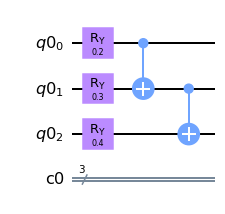

In [14]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst = Ui(cir_i,[0.2,0.3,0.4])

tst.draw(output = 'mpl')

In [15]:
def U(cir,phi_b):
    T = len(phi_b)
    for t in range(T):
        cir = Ui(cir,phi_b[t])
    return cir

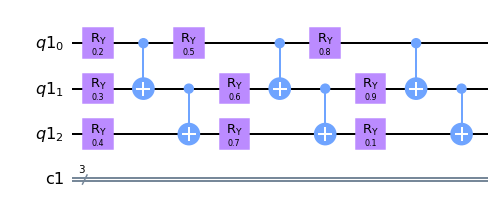

In [16]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
tst = U(cir,[[0.2,0.3,0.4],[0.5,0.6,0.7],[0.8,0.9,0.1]])

tst.draw(output = 'mpl')

### Off Diagonal Blocks

In [17]:
def Ui_off(cir_i,phi_a, phi_b):  
    
    for q in range(0,Q):
        cir_i.ry(phi_a[q],q)
        cir_i.cx(Q,q)
        cir_i.ry(-(phi_b[q]-phi_a[q])/2,q)
        cir_i.cx(Q,q)
        cir_i.ry((phi_b[q]-phi_a[q])/2,q)
    for q in range(0,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(1,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    
    return cir_i

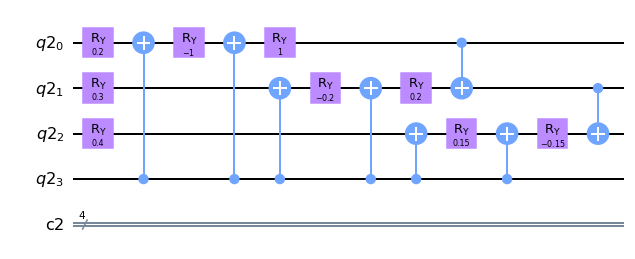

In [18]:
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir_i = QuantumCircuit(qr , cr)
tst = Ui_off(cir_i,[0.2,0.3,0.4],[2.2,0.7,0.1])

tst.draw(output = 'mpl')

In [19]:
#An example block a circuit
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst_a = Ui(cir_i,[0.2,0.3,0.4])

#An example block b circuit
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst_b = Ui(cir_i,[2.2,0.7,0.1])

#The combination of the two blocks
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir_i = QuantumCircuit(qr , cr)
cir_i.h(Q)
tst_off = Ui_off(cir_i,[0.2,0.3,0.4],[2.2,0.7,0.1])

print('A:')
print(1/np.sqrt(2)*qi.Statevector.from_instruction(tst_a).data)
print('B:')
print(1/np.sqrt(2)*qi.Statevector.from_instruction(tst_b).data)
print('AB:')
print(qi.Statevector.from_instruction(tst_off).data)

A:
[0.68180665+0.j 0.01033899+0.j 0.02088826+0.j 0.01386716+0.j
 0.13820905+0.j 0.00209582+0.j 0.103045  +0.j 0.06840885+0.j]
B:
[0.3009187 +0.j 0.21581687+0.j 0.00549678+0.j 0.02958631+0.j
 0.01505849+0.j 0.01079984+0.j 0.1098439 +0.j 0.59123293+0.j]
AB:
[0.68180665+0.j 0.01033899+0.j 0.02088826+0.j 0.01386716+0.j
 0.13820905+0.j 0.00209582+0.j 0.103045  +0.j 0.06840885+0.j
 0.3009187 +0.j 0.21581687+0.j 0.00549678+0.j 0.02958631+0.j
 0.01505849+0.j 0.01079984+0.j 0.1098439 +0.j 0.59123293+0.j]


In [20]:
def U_off(cir,phi_a,phi_b):
    T = len(phi_b)
    cir.h(Q)
    for t in range(T):
        cir = Ui_off(cir,phi_a[t],phi_b[t])
    return cir

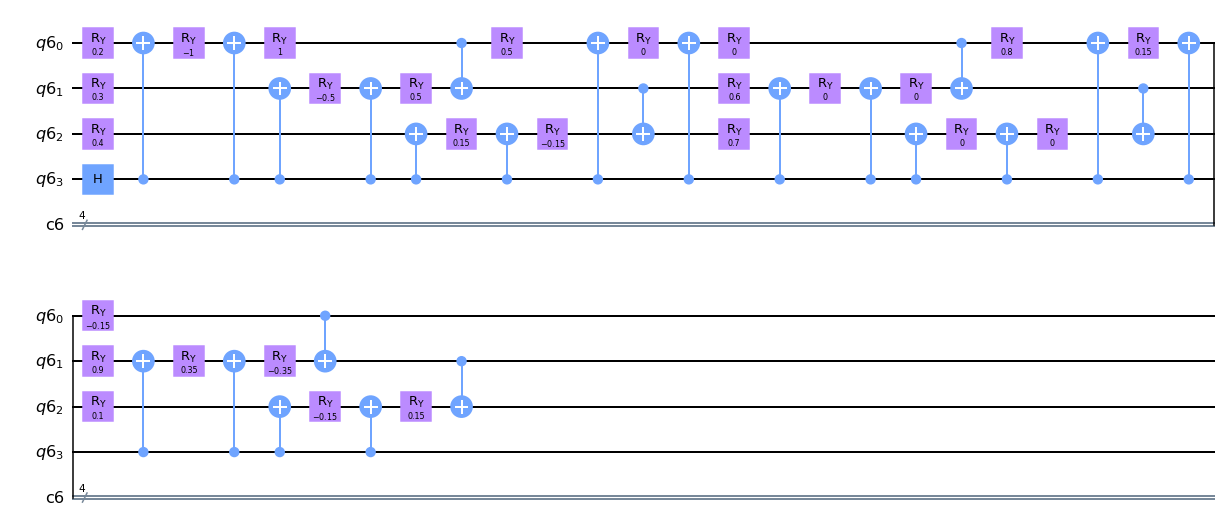

In [21]:
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir = QuantumCircuit(qr , cr)
tst = U_off(cir,[[0.2,0.3,0.4],[0.5,0.6,0.7],[0.8,0.9,0.1]],[[2.2,1.3,0.1],[0.5,0.6,0.7],[0.5,0.2,0.4]])

tst.draw(output = 'mpl')

# Calculating E

$$ E = \sum_{ab}<\psi^a|H_{ab}|\psi^b> = \sum_{ab}<000\ldots|U^{\dagger}(\{\phi^a\})H_{ab}U(\{\phi^b\})|000\ldots>$$

each $H_{ab}$ can be brocken down into its Puali components so that $H_{ab} = \sum_p c_p P_{ab,p}$.  Then we have

$$ E = \sum_{ab}\sum_p c_p <000\ldots|U^{\dagger}(\{\phi^a\})  P_{ab,p}U(\{\phi^b\})|000\ldots>$$.

We cannot measure $<\psi^a|P_{ab,p}|\psi^b>$ directly.  Instead we measure $|<\psi^a|P_{ab,p}|\psi^b>|^2$ which tells us nothing about the sign.  

To fix the issue we need to find a way to use the counts to recreate the desired measurement.  This can be done by looking at the counts in each occupation state. 

First we need to go through the circuit and add a $R_y(-\pi/2)$ gate on each qubit where $P_{ab,p}$ applies an X and an $R_x(\pi/2)$ gate to each qubit where $P_{ab,p}$ applies an Y.  This rotates all of the Pauli terms to Z.   Then we can take the count for each occupation state mulitply that count by $(-1)^n$ where n is the number of up qubits with a Puali term in $P_{ab,p}$. 

for example:

\begin{equation}
\begin{split}
<\psi|XZ|\psi> &= <(R_y(\pi/2)\otimes I)\psi|R^{\dagger}_y(\pi/2)XR_y(\pi/2)\otimes Z|(R^{\dagger}_y(\pi/2)\otimes I)\psi>
\\
& = <(R_y(\pi/2)\otimes I)\psi|ZZ|(R^{\dagger}_y(\pi/2)\otimes I)\psi>
\\
& = |<00|R^{\dagger}_y(\pi/2)\psi>|^2 + (-1)^1|<10|R^{\dagger}_y(\pi/2) \psi>|^2 + (-1)^1|<01|R^{\dagger}_y(\pi/2) \psi>|^2 + (-1)^2|<11|R^{\dagger}_y(\pi/2) \psi>|^2
\end{split}
\end{equation}

This unfortunetly does not work for $|\psi^a> \neq |\psi_b>$



In [22]:
from qiskit import Aer
from qiskit.visualization import *
from qiskit import quantum_info as qi

def measure_pauli(p_label,psi0,method = 'simple'):
    
    #Simple method of calculation####
    if method == 'simple':
        wave0 = qi.Statevector.from_instruction(psi0)
        Op = qi.Operator.from_label(p_label)
        return np.dot(np.conjugate(wave0),np.dot(Op,wave0))
    #################################
        
    #apply rotations#################
    psi = copy.deepcopy(psi0)
    pauli_qs = []
    Z_label = ''
    Q = len(p_label)
    for q,p in enumerate(p_label):
        if p == 'X':
            psi.ry(-np.pi/2,Q-1-q)
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Y':
            psi.rx(np.pi/2,Q-1-q)
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Z':
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'I':
            pauli_qs.append(0)
            Z_label += 'I'
    ################################
    
    #Using matrix multiplication####
    if method == 'matrix':
        # add results
        wave = qi.Statevector.from_instruction(psi)
        r = wave.probabilities_dict()
        z_measure = 0
        for key in list(r.keys()):
            n = 0
            for q in range(len(key)):
                if key[q] == '1' and pauli_qs[q] == 1:
                    n += 1
            z_measure += (-1)**n * r[key] 
        return z_measure
    #################################
    
    #Using the qasm simulator########
    if method == "simulator":
        sim = Aer.get_backend("qasm_simulator")
        psi.measure(psi.qubits,psi.clbits)
        r = execute(psi, backend = sim).result().get_counts()
        z_measure = 0
        total = 0
        for key in list(r.keys()):
            n = 0
            for q in range(len(key)):
                if key[q] == '1' and pauli_qs[q] == 1:
                    n += 1
            z_measure += (-1)**n * r[key] 
            total += r[key]
        return z_measure/total
    ###################################
    
    raise NameError(method + ' is not a recognized method')
    return method + ' is not a recognized method'
  

#Run a test
import copy
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi0 = U(cir,[[1.2,2.3,3.4]])
p_label = blocks['0,0'][7].primitive.to_label()
        
    
print( measure_pauli(p_label,psi0,method = 'simple') )
print( measure_pauli(p_label,psi0,method = 'matrix') )
print( measure_pauli(p_label,psi0,method = 'simulator') )
#print( measure_pauli(p_label,psi0,method = 'Moon_Cheese') )

(-0.2381742951601455+0j)
-0.2381742951601454
-0.216796875


In order to calculate things like 
$$<\psi^a|ZZ|\psi^b>$$ 
we will need to add another qubit and build the combined statevector 
$$ |\psi^{ab}> = |0>|\psi^a> + |1>|\psi_b> $$
then we can calculate
$$ <\psi^{ab}|X\otimes ZZ|\psi^{ab}> = <\psi^{ab}|\left(|1>ZZ|\psi^a> + |0>ZZ|\psi_b> \right) = <\psi^{a}|ZZ|\psi^{b}> + <\psi^{b}|ZZ|\psi^{a}>  $$ 
$$ <\psi^{ab}|Y\otimes ZZ|\psi^{ab}> = <\psi^{ab}|\left(|1>ZZ|\psi^a> + |0>ZZ|\psi_b> \right) = i<\psi^{a}|ZZ|\psi^{b}> - i<\psi^{b}|ZZ|\psi^{a}>  $$ 

$$ <\psi^{ab}|X\otimes ZZ|\psi^{ab}> +  i <\psi^{ab}|Y\otimes ZZ|\psi^{ab}> = <\psi^{a}|ZZ|\psi^{b}> $$

In order to form the combined statevector we need to create a circuit which performs 
$$ U^{ab} = I\otimes U^a + X \otimes U^b$$
This as done in the Ansatz section.   Here we will use that result to calculate E.

In [23]:
import random

alpha = 1/np.sqrt(bL)*np.array([1 for b in range(bL)])

#Create an arbitrary collection of rotation angles
T = 1
phi = []
for b in range(bL):
    phi_b = []
    for ti in range(T):
        phi_t = []
        for q in range(Q):
            rand = random.random()
            phi_t.append(rand)
        phi_b.append(phi_t)
    phi.append(phi_b)

#Find the energy contribution from diagonal blocks
def E_on_block(phi_b,block,method = 'simple'):
    E = 0
    qr = QuantumRegister(Q)
    cr = ClassicalRegister(Q)
    cir = QuantumCircuit(qr , cr)
    psi0 = U(cir,phi_b)
    for p in block:
        psi = copy.deepcopy(psi0)
        w = p.coeff
        p_label = p.primitive.to_label()
        E_p = measure_pauli( p_label,psi,method = method)
        E += w*E_p
    return E
        
        
block = blocks['0,0']
phi_b = phi[0]

M_b = np.sum(block).to_matrix()
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi0 = U(cir,phi_b)
wave = qi.Statevector.from_instruction(psi0).data
print('check:',np.dot(np.conjugate(wave),np.dot(M_b,wave)))

print('simple:',E_on_block(phi_b,block,method = 'simple'))
print('matrix:',E_on_block(phi_b,block,method = 'matrix'))
print('simulator:',E_on_block(phi_b,block,method = 'simulator'))
#print('mooncheese:',E_on_block(phi_b,block,method = 'mooncheese'))

check: (10.256091902482357+0j)
simple: (10.256091902482357+0j)
matrix: 10.256091902482359
simulator: 10.595703125


In [24]:
# Find the energy contribution from off diagonal blocks
def E_off_block(phi_a,phi_b,block,method = 'simple'):
    E = 0
    qr = QuantumRegister(Q+1)
    cr = ClassicalRegister(Q+1)
    cir = QuantumCircuit(qr , cr)
    psi0 = U_off(cir,phi_a,phi_b)
    for p in block:
        psi = copy.deepcopy(psi0)
        w = p.coeff
        p_label = p.primitive.to_label()
        E_px = measure_pauli('X' + p_label,psi,method = method)
        E_py = measure_pauli('Y' + p_label,psi,method = method)
        E += w*(E_px + 1j*E_py)/2
    return E

block = blocks['0,1']
phi_a = phi[0]
phi_b = phi[1]
M_b = np.sum(block).to_matrix()
#A
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi_a = U(cir,phi_a)
wave_a = qi.Statevector.from_instruction(psi_a).data
#B
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi_b = U(cir,phi_b)
wave_b = qi.Statevector.from_instruction(psi_b).data
print('check:',1/2*np.dot(np.conjugate(wave_a),np.dot(M_b,wave_b)))

print('simple:',E_off_block(phi_a,phi_b,block,method = 'simple'))
print('matrix:',E_off_block(phi_a,phi_b,block,method = 'matrix'))
print('simulator:',E_off_block(phi_a,phi_b,block,method = 'simulator'))
#print('mooncheese:',E_off_block(phi_a,phi_b,block,method = 'mooncheese'))

check: (0.14280393359566299+0j)
simple: (0.14280393359566296+0j)
matrix: (0.14280393359566307-1.6002824065886045e-16j)
simulator: (0.1904296875-0.0107421875j)


In [25]:
# The total energy 
def find_E(alpha,phi,blocks,method = 'simple'):
    E = 0
    for key in list(blocks.keys()):
        if key[0] == key[2]:
            E += alpha[int(key[0])]*alpha[int(key[2])]*E_on_block(phi[int(key[0])],blocks[key],method = method)
        else:
            E += 2*alpha[int(key[0])]*alpha[int(key[2])]*E_off_block(phi[int(key[0])],phi[int(key[2])],blocks[key],method = method)
    return E
            
find_E(alpha,phi,blocks)

(6.213888897378828+0j)

In [26]:
#Check against H_complete               
wave_full = []
for b in range(bL):
    qr = QuantumRegister(Q)
    cr = ClassicalRegister(Q)
    cir = QuantumCircuit(qr , cr)
    psi_b = U(cir,phi[b])
    wave_b = alpha[b]*qi.Statevector.from_instruction(psi_b).data
    wave_full.append(wave_b)
wave_full = np.array(wave_full).flatten()

np.dot(np.conjugate(wave_full),np.dot(H_complete,wave_full))


(6.213888897378828+0j)

First we need to inialize our set of parameters.  To do this we need to decide on the number of times we will apply Ui.  As a first attempt let's just have a depth of 1 (i.e. $U = Ui$).  

In this case, we need a parameter for each qubit for each section.

In [27]:
alpha = 1/np.sqrt(bL)*np.array([1 for b in range(bL)])

#number of blocks
T = 2
phi = []
for b in range(bL):
    phi_b = []
    for ti in range(T):
        phi_t = []
        for q in range(Q):
            phi_t.append(0)
        phi_b.append(phi_t)
    phi.append(phi_b)
    
find_E(alpha,phi,blocks)

(7+0j)

# Optimizaition

I will be using the simultaneous perturbation stochastic approximation algorithm.  The algorithm works by calculating the gradiant of the cost function $E(\hat{\phi})$ by randomly purturbating all parameters in $\hat{\phi}$

Let $\hat{\Delta}_k$ be a set of randomly selected purturbations during step $k$ of the algorithm. I will use the Bernoulli distribution to select $\hat{\Delta}_k$.  Then the gradient is 
$$ \hat{g}_k(\hat{\phi}_k) = \frac{E(\hat{\phi}_k + c_k \hat{\Delta}_k)-E(\hat{\phi}_k - c_k \hat{\Delta}_k)}{2 c_k} \hat{\Delta}_k$$.
The gradiant is then used to update the parameters 
$$ \hat{\phi}_{k+1} = \hat{\phi}_k - a_k \hat{g}_k(\hat{\phi}_k) $$

$c_k$ and $a_k$ decrease with each iteration of the algorithm so that we zero in on the the minimum of $E$.  They are given by
$$c_k = \frac{c}{(k+1)^{\gamma}}$$
$$a_k = \frac{a}{(A+k+1)^{\alpha}}$$
where $a$, $A$, $\alpha$, $c$, and $\gamma$ are choosen at the begining of the algorithm.

In [28]:
import copy

In [66]:
#beta = 0.602
beta = 0.201
A = 0
a = 0.1
gamma = 0.101
c = 0.2

beta_a = beta
A_a = A
a_a = a
gamma_a = gamma
c_a = c

def SPSA(k_max,method = 'simple',hold = False, seed = 'False'):
    #Initalization
    if seed == 'True': np.random.seed(0)
    k = 0
    phi_k = np.array(phi)
    alpha_k = np.array(alpha)
    E_l = []
    hold_l = []
    
    #Begin Iterations
    for k in range(k_max):
        #Update c and a
        a_k = a/((A + k + 1)**beta)
        c_k = c/((k + 1)**gamma)
        a_ak = a_a/((A_a + k + 1)**beta_a)
        c_ak = c_a/((k + 1)**gamma_a)

        #Find Delta
        Delta_k = np.array(phi_k)
        for b in range(bL):
            for t in range(T):
                for q in range(Q):
                    Delta_k[b][t][q] = 1 - 2*np.random.binomial(size=None, n=1, p=0.5)
        phi_k_A = phi_k + c_k*Delta_k
        phi_k_B = phi_k - c_k*Delta_k
        
        #Find Delta Alpha
        Delta_ak = np.array(alpha_k)
        for n in range(bL):
            Delta_ak[n] = 1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
        alpha_k_A = alpha_k + c_ak*Delta_ak
        alpha_k_B = alpha_k - c_ak*Delta_ak
        norm_A = 1/np.sqrt(np.dot(alpha_k_A,alpha_k_A))
        norm_B = 1/np.sqrt(np.dot(alpha_k_B,alpha_k_B))
        alpha_k_A = norm_A*alpha_k_A
        alpha_k_B = norm_B*alpha_k_B
            
        #Find E    
        E_A = find_E(alpha_k_A, phi_k_A, blocks, method = method)
        E_B = find_E(alpha_k_B, phi_k_B, blocks, method = method)
        
        #Calculate gradiant
        g = np.real((E_A-E_B)/(2*c_k)) 
        
        #Update phi
        g_k = g * Delta_k
        phi_k = phi_k - a_k * g_k
        
        #Update alpha
        g_ak = g * Delta_ak
        alpha_k = alpha_k - a_ak * g_ak
        norm = 1/np.sqrt(np.dot(alpha_k,alpha_k))
        alpha_k = norm*alpha_k

        
        #Calculate new E
        E_f = np.real(find_E(alpha_k,phi_k,blocks, method = method))
        
        #Print and save E
        print('k=',k,'c_k=',c_k,'a_k=',a_k,'g=',g,'E_A=',E_A,'E_B=',E_B,'E_f=',E_f)
        #print('k = ', k ,' E_f = ', E_f)
        E_l.append(E_f)
        
        if hold == True:
            hold_k = {'E':E_f,'c':c_k,'a':a_k,'phi':phi_k,'Delta':Delta_k,'c_a':c_ak,'a_a':a_ak,'alpha':alpha_k,'Delta_a':Delta_ak}
            hold_l.append(hold_k)
    if hold == True:
        return hold_l
    else:
        return E_l,phi_k

In [67]:
out = SPSA(1000,method = 'simple',hold = True, seed = 'True')

k= 0 c_k= 0.2 a_k= 0.1 g= 8.523911606253755 E_A= (7.905451899927731+0j) E_B= (4.4958872574262285+0j) E_f= 0.6287945111769442
k= 1 c_k= 0.1864772972873665 a_k= 0.08699473527086508 g= 3.864094799792082 E_A= (1.2409773652809974+0j) E_B= (-0.20015454417379264+0j) E_f= 0.15925536809405738
k= 2 c_k= 0.17899493787135265 a_k= 0.08018601442725502 g= -7.293419348020966 E_A= (-1.6748108687394834+0j) E_B= (0.936159417397985+0j) E_f= -1.8299214204678982
k= 3 c_k= 0.17386891201800433 a_k= 0.07568083964847896 g= 13.272468508109167 E_A= (1.2251563575285749+0j) E_B= (-3.390182961067757+0j) E_f= 0.3801093657655597
k= 4 c_k= 0.16999416915812673 a_k= 0.0723614114000324 g= 4.057692676143036 E_A= (0.7745991146622552+0j) E_B= (-0.6049690756976472+0j) E_f= -1.616480038256433
k= 5 c_k= 0.1668924612118496 a_k= 0.06975761097524817 g= 4.883818904912921 E_A= (-0.5537018108784193+0j) E_B= (-2.1838469251861743+0j) E_f= -2.6237167318296652
k= 6 c_k= 0.16431419883627008 a_k= 0.06762936255245743 g= -0.088889220096673 E

k= 52 c_k= 0.1339300814134255 a_k= 0.04502156113543322 g= 12.377450746317784 E_A= (-1.1270066771753195+0j) E_B= (-4.44243264946533+0j) E_f= -1.331403756427944
k= 53 c_k= 0.13367747261071303 a_k= 0.04485272714786551 g= -15.999907397978134 E_A= (-3.0367558535608263+0j) E_B= (1.2408985123735072+0j) E_f= -2.0248295268597825
k= 54 c_k= 0.1334299625175472 a_k= 0.0446876070401925 g= 2.112357544502276 E_A= (-1.5913435228502486+0j) E_B= (-2.155047098823442+0j) E_f= -2.126741244877469
k= 55 c_k= 0.13318735827857978 a_k= 0.044526053784514005 g= -5.228267588018912 E_A= (-2.900028610634972+0j) E_B= (-1.5073503137914503+0j) E_f= -3.3289304487779594
k= 56 c_k= 0.1329494776149124 a_k= 0.044367928668733035 g= 0.1845236120596108 E_A= (-2.8838393104337863+0j) E_B= (-2.9329039460956703+0j) E_f= -3.3257700172904805
k= 57 c_k= 0.13271614807033782 a_k= 0.04421310068999025 g= -4.373639352780709 E_A= (-3.778483355061156+0j) E_B= (-2.617578219161354+0j) E_f= -3.907357889634378
k= 58 c_k= 0.13248720632325808 a_k

k= 104 c_k= 0.12499420436933971 a_k= 0.03924107993533996 g= -4.67557704659178 E_A= (-7.705522305928475+0j) E_B= (-6.536682240115901+0j) E_f= -7.520675483401643
k= 105 c_k= 0.12487459803726274 a_k= 0.03916638792458081 g= -6.715007527857035 E_A= (-7.940745675002483+0j) E_B= (-6.263677943285802+0j) E_f= -7.562216879671795
k= 106 c_k= 0.1247562276299998 a_k= 0.03909253743209213 g= -1.6005652200473077 E_A= (-7.731884537656228+0j) E_B= (-7.332523579798463+0j) E_f= -7.655924928393546
k= 107 c_k= 0.12463906900325862 a_k= 0.03901951124404904 g= 17.134608170678757 E_A= (-5.0040210075658+0j) E_B= (-9.275304227823858+0j) E_f= -5.551685864268693
k= 108 c_k= 0.12452309870250361 a_k= 0.0389472926540164 g= 3.6673621417733417 E_A= (-5.104537955869874+0j) E_B= (-6.017880551785607+0j) E_f= -6.064557157733943
k= 109 c_k= 0.12440829393713411 a_k= 0.038875865443499934 g= 10.78808970348392 E_A= (-4.461475285309637+0j) E_B= (-7.1457309550120325+0j) E_f= -5.549410006874541
k= 110 c_k= 0.12429463255585414 a_k= 

k= 155 c_k= 0.12009485751575995 a_k= 0.03623947986391976 g= -6.153192167699124 E_A= (-7.406658536047596+0j) E_B= (-5.928725062753763+0j) E_f= -6.845370569019173
k= 156 c_k= 0.12001737694913578 a_k= 0.03619296558574027 g= -11.768849860603195 E_A= (-7.709907750863842+0j) E_B= (-4.884974770908246+0j) E_f= -5.34987715603967
k= 157 c_k= 0.11994043783840477 a_k= 0.036146805773307845 g= -12.185844275250222 E_A= (-6.682461573728147+0j) E_B= (-3.7593105781198872+0j) E_f= -5.384157216599434
k= 158 c_k= 0.1198640330085065 a_k= 0.03610099550743392 g= 14.020316682453124 E_A= (-3.158133637829042+0j) E_B= (-6.519197041059593+0j) E_f= -5.857324479644775
k= 159 c_k= 0.11978815542383568 a_k= 0.03605552996759187 g= 7.956050706532541 E_A= (-4.53388934423205+0j) E_B= (-6.439970621420126+0j) E_f= -6.199956655763908
k= 160 c_k= 0.11971279818467995 a_k= 0.03601040442933621 g= -5.760335591062076 E_A= (-6.309087329725554+0j) E_B= (-4.929915545547868+0j) E_f= -5.867686769416267
k= 161 c_k= 0.11963795452377009 a_

k= 206 c_k= 0.11671239759862044 a_k= 0.034236547318955354 g= 8.894997894632638 E_A= (-7.2047891949002265+0j) E_B= (-9.281102256734739+0j) E_f= -9.413889744145433
k= 207 c_k= 0.11665560190439503 a_k= 0.03420339923508381 g= -9.18295321797657 E_A= (-9.784310289937995+0j) E_B= (-7.641824420132079+0j) E_f= -8.445714366928371
k= 208 c_k= 0.11659910605258784 a_k= 0.03417044199918816 g= -2.2744749813467506 E_A= (-8.203258787893898+0j) E_B= (-7.6728552887658825+0j) E_f= -8.373343860198489
k= 209 c_k= 0.11654290703689603 a_k= 0.03413767360717755 g= -0.0609113513076276 E_A= (-8.119978068159709+0j) E_B= (-8.105780496253836+0j) E_f= -8.375015655670227
k= 210 c_k= 0.116487001895294 a_k= 0.03410509208542231 g= -3.5902635185055267 E_A= (-8.250702326905307+0j) E_B= (-7.4142642603357904+0j) E_f= -8.221741786945119
k= 211 c_k= 0.11643138770917519 a_k= 0.034072695490149144 g= 4.35905025279277 E_A= (-7.288081926798028+0j) E_B= (-8.303142466851414+0j) E_f= -8.175307983536454
k= 212 c_k= 0.11637606160251421 

k= 257 c_k= 0.11414487198295892 a_k= 0.032754007120431174 g= -5.2150826767331235 E_A= (-9.36533116316339+0j) E_B= (-8.174781274130892+0j) E_f= -9.28479134274252
k= 258 c_k= 0.11410028244900672 a_k= 0.03272854868819017 g= -10.529321947410384 E_A= (-9.990102617249839+0j) E_B= (-7.587305400857739+0j) E_f= -8.000988884935715
k= 259 c_k= 0.11405588206202913 a_k= 0.03270320803555191 g= -2.301343662388944 E_A= (-7.970665043496009+0j) E_B= (-7.445701480812746+0j) E_f= -8.027499635572891
k= 260 c_k= 0.11401166929679721 a_k= 0.03267798416776113 g= -1.4598014111733093 E_A= (-7.829329098753366+0j) E_B= (-7.4964603072939875+0j) E_f= -8.000657873039334
k= 261 c_k= 0.11396764264616556 a_k= 0.03265287610223464 g= -4.1069091286161425 E_A= (-8.070117077701001+0j) E_B= (-7.134007573800202+0j) E_f= -7.995586719863804
k= 262 c_k= 0.11392380062078987 a_k= 0.03262788286836662 g= -14.582048884924673 E_A= (-9.700290534008895+0j) E_B= (-6.377805674391356+0j) E_f= -10.409174413669772
k= 263 c_k= 0.11388014174884

k= 308 c_k= 0.11208414653823812 a_k= 0.031587724796949865 g= -2.9138650529437715 E_A= (-5.564508270222349+0j) E_B= (-4.911312115048748+0j) E_f= -5.479220074064138
k= 309 c_k= 0.11204757574107686 a_k= 0.03156721727844525 g= 21.576193105314186 E_A= (-3.037143863143312+0j) E_B= (-7.872264125486895+0j) E_f= -7.081973648003056
k= 310 c_k= 0.11201113459920035 a_k= 0.031546789056552234 g= 0.9427120907916788 E_A= (-6.738421359908955+0j) E_B= (-6.9496098616888755+0j) E_f= -7.100068022544138
k= 311 c_k= 0.11197482223825145 a_k= 0.031526439571155446 g= 0.4948262260960073 E_A= (-6.779825204213216+0j) E_B= (-6.890641361625066+0j) E_f= -7.09921388838905
k= 312 c_k= 0.11193863779254803 a_k= 0.03150616826787509 g= 0.34366328299112847 E_A= (-6.760955736572813+0j) E_B= (-6.837894136087496+0j) E_f= -7.095136078551225
k= 313 c_k= 0.1119025804049696 a_k= 0.03148597459799005 g= -2.221144239423856 E_A= (-6.742276254614458+0j) E_B= (-6.245172710928132+0j) E_f= -6.98037068913757
k= 314 c_k= 0.11186664922684557

k= 359 c_k= 0.11036806871702996 a_k= 0.03063255326460758 g= -23.510012206786293 E_A= (-7.757624843519167+0j) E_B= (-2.5681155579655623+0j) E_f= -8.229832854118948
k= 360 c_k= 0.11033715159997054 a_k= 0.030615478560069673 g= 11.15249106287432 E_A= (-6.309587398930842+0j) E_B= (-8.770655593174203+0j) E_f= -7.235977059768374
k= 361 c_k= 0.1103063286323783 a_k= 0.030598460566579378 g= 5.906682596194731 E_A= (-6.093948664385527+0j) E_B= (-7.397037607551538+0j) E_f= -7.010649640068554
k= 362 c_k= 0.11027559926865095 a_k= 0.030581498939897738 g= -6.727510408166414 E_A= (-7.431497388589365+0j) E_B= (-5.9477369048960895+0j) E_f= -6.983653495376879
k= 363 c_k= 0.11024496296784006 a_k= 0.030564593338816344 g= 6.555406466472076 E_A= (-6.114113679938506+0j) E_B= (-7.559514766209213+0j) E_f= -7.4359812676258175
k= 364 c_k= 0.11021441919359877 a_k= 0.030547743425122433 g= -9.771920231611237 E_A= (-8.099213038202674+0j) E_B= (-5.9452000127362545+0j) E_f= -7.425782030590731
k= 365 c_k= 0.11018396741413

k= 410 c_k= 0.10890102605464445 a_k= 0.029827564520129805 g= -6.366315646061792 E_A= (-7.882007901976283+0j) E_B= (-6.495411289888551+0j) E_f= -7.6283782340881645
k= 411 c_k= 0.10887430027253854 a_k= 0.029812998592004987 g= -1.4162962820158693 E_A= (-7.270262642792712+0j) E_B= (-6.961866109426561+0j) E_f= -7.582700628710746
k= 412 c_k= 0.10884764581530884 a_k= 0.029798475062507324 g= -4.91570203760755 E_A= (-7.930811489516177+0j) E_B= (-6.86068630086998+0j) E_f= -7.876517452505733
k= 413 c_k= 0.10882106232059632 a_k= 0.029783993706009666 g= 1.5853324291046857 E_A= (-7.104825611101843+0j) E_B= (-7.44986072923477+0j) E_f= -7.81648305820109
k= 414 c_k= 0.1087945494287525 a_k= 0.029769554298626894 g= 6.194806373795221 E_A= (-6.965239750671943+0j) E_B= (-8.313162087142773+0j) E_f= -8.178309451916856
k= 415 c_k= 0.10876810678281275 a_k= 0.029755156618198247 g= -4.231661392317621 E_A= (-8.201211912382279+0j) E_B= (-7.280672316005661+0j) E_f= -8.14487424777111
k= 416 c_k= 0.10874173402846987 a

k= 461 c_k= 0.10762202418846145 a_k= 0.029134459326008517 g= 2.0079118777880023 E_A= (-7.87324964249435+0j) E_B= (-8.305440723853549+0j) E_f= -8.569761989028903
k= 462 c_k= 0.10759852442220019 a_k= 0.029121800393488412 g= -10.513421234757 E_A= (-9.166246132129812+0j) E_B= (-6.903788909152054+0j) E_f= -8.604942698811772
k= 463 c_k= 0.10757508047134981 a_k= 0.029109174255126935 g= -5.157030306925214 E_A= (-8.721288944958438+0j) E_B= (-7.611753044437099+0j) E_f= -8.552806903695048
k= 464 c_k= 0.10755169208347641 a_k= 0.02909658075556477 g= 7.26663743097762 E_A= (-7.50458629825729+0j) E_B= (-9.067664601174828+0j) E_f= -9.25050470276948
k= 465 c_k= 0.1075283590078275 a_k= 0.0290840197405107 g= -0.7347557166883023 E_A= (-8.712381119552694+0j) E_B= (-8.554366966578467+0j) E_f= -9.227408411849353
k= 466 c_k= 0.10750508099531728 a_k= 0.029071491056731995 g= 3.3134387579300815 E_A= (-8.422770114580903+0j) E_B= (-9.135193118669497+0j) E_f= -9.185266393424419
k= 467 c_k= 0.107481857798512 a_k= 0.0

k= 512 c_k= 0.10648983197579086 a_k= 0.028527677064524973 g= -1.3914151176001177 E_A= (-9.50504041125243+0j) E_B= (-9.208697287088807+0j) E_f= -9.651683583355837
k= 513 c_k= 0.10646888860918197 a_k= 0.028516512618951825 g= -2.1018523806867884 E_A= (-9.67457916888954+0j) E_B= (-9.227015394904969+0j) E_f= -9.704518845334974
k= 514 c_k= 0.10644799005578454 a_k= 0.028505374229526235 g= -11.036632960720672 E_A= (-10.30523998010241+0j) E_B= (-7.955585188798135+0j) E_f= -9.409298249041752
k= 515 c_k= 0.1064271361329731 a_k= 0.0284942617850194 g= -12.28141943186681 E_A= (-10.219866637342603+0j) E_B= (-7.605714041779743+0j) E_f= -9.068829312207468
k= 516 c_k= 0.10640632665921859 a_k= 0.028483175174891722 g= 0.18922885137102996 E_A= (-8.643133902156139+0j) E_B= (-8.683404196100808+0j) E_f= -9.064977189216561
k= 517 c_k= 0.10638556145407957 a_k= 0.02847211428928722 g= 2.3233771632519638 E_A= (-8.59790502229729+0j) E_B= (-9.092252590261584+0j) E_f= -9.145453730710084
k= 518 c_k= 0.1063648403381936

k= 563 c_k= 0.10547530895110692 a_k= 0.027989355619107772 g= 3.600268095845684 E_A= (-5.122463856639062+0j) E_B= (-5.881942636071336+0j) E_f= -5.887646710137398
k= 564 c_k= 0.10545643905556829 a_k= 0.027979391295854465 g= -12.398569312113153 E_A= (-6.57971214427288+0j) E_B= (-3.9646942061946797+0j) E_f= -5.3505967127684135
k= 565 c_k= 0.10543760589550284 a_k= 0.027969448130923537 g= 6.27557650904694 E_A= (-4.190888509449378+0j) E_B= (-5.5142520349053115+0j) E_f= -5.109056743886922
k= 566 c_k= 0.10541880933468037 a_k= 0.027959526042123917 g= -2.3686001357950643 E_A= (-5.170489323765341+0j) E_B= (-4.671099311554385+0j) E_f= -5.18066201152596
k= 567 c_k= 0.105400049237615 a_k= 0.027949624947728062 g= 7.66464563762352 E_A= (-4.170104606543281+0j) E_B= (-5.785812661732061+0j) E_f= -5.905417161021662
k= 568 c_k= 0.1053813254695599 a_k= 0.027939744766468527 g= -2.6371721801107384 E_A= (-6.20947368786171+0j) E_B= (-5.653656288198673+0j) E_f= -6.127351713482873
k= 569 c_k= 0.1053626378965018 a_

k= 614 c_k= 0.10455711922176397 a_k= 0.027506548680484966 g= 10.780449983445486 E_A= (-6.20635693521878+0j) E_B= (-8.460702523585526+0j) E_f= -6.912217427430847
k= 615 c_k= 0.10453996340540049 a_k= 0.02749756750283546 g= -8.28473583903567 E_A= (-7.525577328896422+0j) E_B= (-5.793405366024024+0j) E_f= -6.356713919562523
k= 616 c_k= 0.1045228382249081 a_k= 0.027488603818520002 g= 2.9255546855513694 E_A= (-5.928233524177297+0j) E_B= (-6.539808082409312+0j) E_f= -6.522507029985619
k= 617 c_k= 0.1045057435760589 a_k= 0.02747965756519594 g= 13.937996612360925 E_A= (-4.503622069765065+0j) E_B= (-7.416823469635801+0j) E_f= -5.923327163757294
k= 618 c_k= 0.10448867935514748 a_k= 0.027470728680843225 g= 14.669134523658416 E_A= (-4.289060066724466+0j) E_B= (-7.3545770540446025+0j) E_f= -6.907325946023007
k= 619 c_k= 0.10447164545898752 a_k= 0.027461817103762224 g= -11.57733503170173 E_A= (-7.715920447421285+0j) E_B= (-5.296913965837566+0j) E_f= -7.257887455507332
k= 620 c_k= 0.10445464178490836 a

k= 665 c_k= 0.10371918571334494 a_k= 0.02706959012495199 g= -2.2806300639974513 E_A= (-11.478153146917721+0j) E_B= (-11.005062960615343+0j) E_f= -11.525254270445117
k= 666 c_k= 0.1037034695152444 a_k= 0.027061427831952773 g= 4.773628170140818 E_A= (-10.659732760864882+0j) E_B= (-11.649816367703503+0j) E_f= -11.515046898591953
k= 667 c_k= 0.10368777923808949 a_k= 0.027053280222760885 g= 1.5750724226993265 E_A= (-10.877844656907579+0j) E_B= (-11.20447618020528+0j) E_f= -11.482451171137328
k= 668 c_k= 0.1036721148004205 a_k= 0.027045147249037938 g= 12.397094212191734 E_A= (-9.712780458196377+0j) E_B= (-12.283246406912317+0j) E_f= -11.456216547993701
k= 669 c_k= 0.10365647612115503 a_k= 0.027037028862676615 g= -2.1422919826875475 E_A= (-11.51390662580026+0j) E_B= (-11.069781750304273+0j) E_f= -11.550271828445199
k= 670 c_k= 0.10364086311958555 a_k= 0.027028925015799232 g= -16.919758204653245 E_A= (-12.796310263751346+0j) E_B= (-9.289153575541443+0j) E_f= -10.226291750270736
k= 671 c_k= 0.1

k= 716 c_k= 0.1029491015771502 a_k= 0.026671082926228634 g= 7.287548210252665 E_A= (-7.904074479947829+0j) E_B= (-9.40456756183919+0j) E_f= -8.88594203571611
k= 717 c_k= 0.10293461080482806 a_k= 0.026663612351025885 g= 1.299626818316087 E_A= (-8.622776789715802+0j) E_B= (-8.890329951185569+0j) E_f= -8.93031727617858
k= 718 c_k= 0.10292014223601867 a_k= 0.026656154261430042 g= -4.962581333712153 E_A= (-9.079767906741957+0j) E_B= (-8.058268753295025+0j) E_f= -8.905720217835045
k= 719 c_k= 0.10290569580589046 a_k= 0.0266487086192521 g= -10.281232549966242 E_A= (-9.171167036461462+0j) E_B= (-7.055172257868571+0j) E_f= -7.300046561141979
k= 720 c_k= 0.10289127144989084 a_k= 0.02664127538647268 g= 7.715102485749193 E_A= (-6.300172008251177+0j) E_B= (-7.887805416501073+0j) E_f= -7.5314771866524906
k= 721 c_k= 0.10287686910374468 a_k= 0.026633854525241064 g= -7.323034118976341 E_A= (-7.870268650440916+0j) E_B= (-6.363527005440545+0j) E_f= -7.54052512668938
k= 722 c_k= 0.10286248870345266 a_k= 

k= 767 c_k= 0.10223709774111411 a_k= 0.026305247648079344 g= -1.746376823650688 E_A= (-8.610234978888377+0j) E_B= (-8.253145982863593+0j) E_f= -8.723068614789094
k= 768 c_k= 0.10222366212652029 a_k= 0.026298368449466952 g= 0.8519773247796132 E_A= (-8.25580778629275+0j) E_B= (-8.429992270668206+0j) E_f= -8.712311036572792
k= 769 c_k= 0.10221024573433693 a_k= 0.026291499986190077 g= 4.8046490297384565 E_A= (-7.893501617995335+0j) E_B= (-8.875670333988957+0j) E_f= -8.763588533314126
k= 770 c_k= 0.1021968485121518 a_k= 0.02628464222758629 g= -8.530342636306276 E_A= (-9.2607008997941+0j) E_B= (-7.517152631475416+0j) E_f= -9.240755482114967
k= 771 c_k= 0.10218347040776328 a_k= 0.026277795143120366 g= 13.366681959751423 E_A= (-7.406121275965054+0j) E_B= (-10.13782917693354+0j) E_f= -8.633782163966965
k= 772 c_k= 0.10217011136917928 a_k= 0.02627095870238359 g= -3.285572265961682 E_A= (-8.509294074474159+0j) E_B= (-7.837919505824575+0j) E_f= -8.573251652909727
k= 773 c_k= 0.10215677134461615 a_

k= 818 c_k= 0.10157534862682992 a_k= 0.0259674877696686 g= 4.198310391594431 E_A= (-6.307811787297753+0j) E_B= (-7.160701470637448+0j) E_f= -7.149833875972316
k= 819 c_k= 0.10156283065329288 a_k= 0.025961119465033454 g= 3.4739196467374787 E_A= (-6.350788760319986+0j) E_B= (-7.056430985889477+0j) E_f= -7.127173575510781
k= 820 c_k= 0.10155032947615303 a_k= 0.02595476048081126 g= -8.188936222721358 E_A= (-7.600250713501466+0j) E_B= (-5.93707237054835+0j) E_f= -7.347569233168425
k= 821 c_k= 0.10153784505245589 a_k= 0.0259484107920334 g= -4.3846303490365255 E_A= (-7.481557968751829+0j) E_B= (-6.591146134766297+0j) E_f= -7.4723541028137435
k= 822 c_k= 0.10152537733940896 a_k= 0.025942070373828403 g= 7.64565716936418 E_A= (-6.471245743084702+0j) E_B= (-8.023702201339614+0j) E_f= -7.665327448058782
k= 823 c_k= 0.10151292629438088 a_k= 0.025935739201421473 g= -2.8781770257759973 E_A= (-7.76725311412277+0j) E_B= (-7.182908769563212+0j) E_f= -7.760175363676514
k= 824 c_k= 0.10150049187490061 a_k

k= 869 c_k= 0.10095749151626948 a_k= 0.02565409095818986 g= -10.880975691999051 E_A= (-10.452465414936967+0j) E_B= (-8.25543339270951+0j) E_f= -8.192279483506919
k= 870 c_k= 0.10094577857399561 a_k= 0.025648168066086434 g= -2.70045252079365 E_A= (-8.037711963157209+0j) E_B= (-7.492513398729961+0j) E_f= -8.189440499671624
k= 871 c_k= 0.10093408042828501 a_k= 0.025642253335284873 g= 15.227679361876843 E_A= (-6.094114394219365+0j) E_B= (-9.168098021114991+0j) E_f= -8.384546807644055
k= 872 c_k= 0.10092239704350928 a_k= 0.025636346745199552 g= -10.860016315223705 E_A= (-9.389635235965997+0j) E_B= (-7.197597479038007+0j) E_f= -10.25166090083868
k= 873 c_k= 0.10091072838416647 a_k= 0.025630448275320274 g= -1.215602408973177 E_A= (-9.748597078164854+0j) E_B= (-9.503262429134793+0j) E_f= -10.213543835839857
k= 874 c_k= 0.10089907441488051 a_k= 0.025624557905211898 g= -0.06236743017662011 E_A= (-9.769004390021301+0j) E_B= (-9.75641875806439+0j) E_f= -10.212561572690616
k= 875 c_k= 0.10088743510

k= 920 c_k= 0.10037828538968087 a_k= 0.02536201846070387 g= -2.78977200145391 E_A= (-7.874329624055958+0j) E_B= (-7.314264563787795+0j) E_f= -7.904400644996862
k= 921 c_k= 0.10036728413927834 a_k= 0.025356487033376507 g= 2.7775484299754063 E_A= (-7.421608168758568+0j) E_B= (-7.979158153722464+0j) E_f= -8.01112430231446
k= 922 c_k= 0.10035629601810715 a_k= 0.02535096280661468 g= -0.7668996727162801 E_A= (-7.87067269943252+0j) E_B= (-7.716746278289911+0j) E_f= -8.03058551416643
k= 923 c_k= 0.10034532099629938 a_k= 0.02534544576325897 g= -25.126371858783504 E_A= (-10.139388493034177+0j) E_B= (-5.096760793750149+0j) E_f= -6.961819896286625
k= 924 c_k= 0.1003343590440873 a_k= 0.025339935886209364 g= -1.9303089602245194 E_A= (-6.809838515161503+0j) E_B= (-6.422485890599131+0j) E_f= -6.96944288414946
k= 925 c_k= 0.10032341013180295 a_k= 0.025334433158424985 g= 0.9144110532113928 E_A= (-6.566282153305497+0j) E_B= (-6.749755823546258+0j) E_f= -6.992961235120231
k= 926 c_k= 0.10031247422987759 a

k= 971 c_k= 0.09983336342411664 a_k= 0.025088753281608145 g= 4.0006784458512605 E_A= (-8.683897054221992+0j) E_B= (-9.48269942467739+0j) E_f= -9.477756628039561
k= 972 c_k= 0.09982299566369167 a_k= 0.02508356837800595 g= -1.0836468302220468 E_A= (-9.16738320377662+0j) E_B= (-8.951037458108162+0j) E_f= -9.467849062433132
k= 973 c_k= 0.09981263962829394 a_k= 0.025078389870323015 g= -9.267955418543565 E_A= (-9.935458605204609+0j) E_B= (-8.085340416640243+0j) E_f= -9.133536127532812
k= 974 c_k= 0.09980229529264584 a_k= 0.02507321774411504 g= 6.239951620028336 E_A= (-7.968118745652632+0j) E_B= (-9.213641734040415+0j) E_f= -8.861020385054925
k= 975 c_k= 0.09979196263155014 a_k= 0.02506805198498512 g= 3.4568158937611817 E_A= (-8.114462403465653+0j) E_B= (-8.804387288454382+0j) E_f= -8.842966998380867
k= 976 c_k= 0.09978164161988964 a_k= 0.025062892578583535 g= -7.481916552231842 E_A= (-9.052830686375758+0j) E_B= (-7.559714854286322+0j) E_f= -8.629939020790335
k= 977 c_k= 0.09977133223262673 a

In [68]:
e,ys = np.linalg.eig(H_complete)

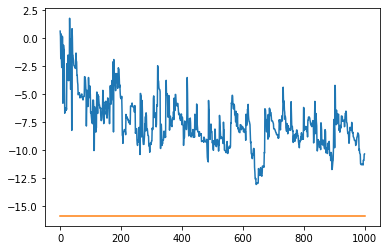

In [69]:
import matplotlib.pyplot as plt

E0 = [np.sort(e)[0] for i in range(len(out))]

El = [out[i]['E'] for i in range(len(out))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)
plt.plot(tl,E0)

In [70]:
import pickle

file_to_store = open("VQE_ByQubit"+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_x_"+str(x)+"_y_"+str(y)+"_z_"+str(z)+".pickle", "wb")

pickle.dump(out, file_to_store)

In [71]:
import pickle

file_to_read = open("VQE_ByQubit"+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_x_"+str(x)+"_y_"+str(y)+"_z_"+str(z)+".pickle", "rb")

loaded_object = pickle.load(file_to_read)

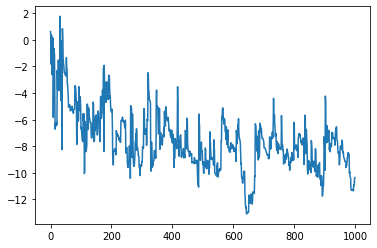

In [72]:
import matplotlib.pyplot as plt

El = [loaded_object[i]['E'] for i in range(len(loaded_object))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)

In [73]:
A

0